# 多层感知机

## 1. 激活函数 

将神经网络当成一种语言，通过直觉搭建相应的结构，来描述对问题的理解，帮助模型能够优化work。

1. $$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$  
2. sigmoid 导数 
$$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right).$$  
3.  反向传播需要正向传播的中间值，这些中间值的大小大致与网络层数和批处理大小成正比。  
  因此，使用较大的批处理大小训练更深的网络更容易导致内存不足错误。
4. 输出层不需要激活函数，激活函数是为了防止神经网络层数塌陷。

## 2. 正则化


正则化通过限制模型参数的取值来约束模型的复杂度。模型过拟合是由于模型去拟合数据集的**噪音**，如果噪音**较大**，则模型学得的参数相对**较大**，这种情况 L2 正则化是比较适用的。

使用均方范数作为参数 w 的硬性限制  


<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202406272021178.png" width='500px' >
</div>

通过拉格朗日证明其与下方的柔性限制效果相同   

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202406272018133.png" width='500px' >
</div>

图像解释如下，通过加入新的损失部分，通过正则项的梯度方向将最优值向原点拉动。所以**如果模型时间的参数就是较大的时候，L2没有效果**
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202406272028894.png" width='500px' >
</div>

L2 正则化又称为权重衰退（通过计算柔性限制的梯度证明）  
参数选择为 0.01, 0.001, 0.0001 

**框架实现： 通过声明优化器内部的权重衰减参数**

## 2. 梯度消失、爆炸
1. 对称性: 若参数均初始化为相同的值，则隐藏层的值均相同，反向传播时隐藏层输出的梯度相同，导致权重梯度相同。无论如何迭代权重均相同，导致隐藏层压缩为一个unit，失去拟合能力。  
2. 梯度消失及爆炸在 float16 时的问题更加严重, 区间为 6e-5 ~ 6e 4。超出值则会变为 INF无穷大。  
3. 梯度合理范围： [1e-6, 1e3]
4. 将梯度由乘法变成加法： ResNet， LSTM
5. 归一化: 梯度归一化， 梯度裁剪
6. 合理的权重初始及激活函数

## 3. 初始化方法
用于稳定输入输出的方差，确保激活的尺度一致，稳定激活函数的输入，以防止(或者说减少)梯度消失、爆炸，稳定模型训练过程。(还有个作用是能够保证各层的梯度也为均值为0，方差为1的正态分布)
1. Xavier 初始化：适用于 tanh 和 sigmoid 激活函数，权重按照标准差为[ [**1**] ](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#exercises)的正态分布初始化; 根据采样标准差的不同也能表示均匀采样的方式。
2. He 初始化：适用于 ReLU 激活函数，权重按照标准差为 的正态分布初始化。

以上推导不包含激活函数的分析，在激活函数为线性的假设下，为保持输入、输出、梯度的均值及方差符合标准正态分布，则通过推导得出激活函数需要为**I**单位矩阵，分线性激活函数在原点附近可以近似这种性质。也能适当解释为什么 ReLu 可以使得数值优化更加稳定。  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202407012259056.png" width='500px' >
</div>

## 4. 模型简单性
    简单性的另一个有用概念是平滑度，即函数不应该对其输入的微小变化敏感。例如，当我们对图像进行分类时，我们会期望向像素添加一些随机噪声应该是无害的。
    


## 5. Dropout  
训练时使用下述公式处理输出，
$$  \begin{aligned}
h' =
\begin{cases}
    0 & \textrm{ with probability } p \\
    \frac{h}{1-p} & \textrm{ otherwise}
\end{cases}
\end{aligned}
$$  本质上保持了当前层的输出期望， 即使用一个期望为 h 的随机变量替换原始的激活变量  
通过随机将一些神经元的激活值设为零，Dropout 强迫网络不要过度依赖任何特定的一组神经元，从而促进冗余和鲁棒性。这种随机性有助于模型在处理未见过的数据时表现更好。  

**用于原全连接层。  BN 用于卷积层。**  

深度学习一定要**优先保证模型拟合的能力(过拟合)**，再通过多种正则化方法防止过拟合。

dropout 实现时使用的是矩阵逐元素乘法而不是赋值0， 这是因为乘法速度更快.

In [ ]:
%%time
m = torch.randn((10000, 10000))

In [ ]:
%%time
m[torch.randn((10000, 10000)) < 0.7] = 1

In [ ]:
%%time
m * (torch.randn((10000, 10000)) < 0.7)

cuda 中数字加法的**结果会与数字顺序**相关，因为精度的问题。

## 6. 预测值 / loss 函数的选择  
当我们更加关心预测值的相对误差而不是绝对误差的时候，我们可以使用预测的log值。 
a small value $\delta$ for $|\log y - \log \hat{y}| \leq \delta$
translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$.
This leads to the following root-mean-squared-error between the logarithm of the predicted price and the logarithm of the label price:

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

## 7.VC 维度  
1. 提供为什么一个模型好的理论依据：  衡量训练误差和泛化误差的间隔 
2. 但深度学习中应用困难  
<img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202406270110028.png" />

## 其他

1. 深度学习中传统机器学习的理论难以适用。
2. 提前停止的理论基础 ： 
   一项新的研究 （Rolnick等人，2017 年）表明，在标签噪声的设置中，神经网络倾向于首先拟合干净标记的数据，然后才插入错误标记的数据；值得注意的是，当没有标签噪声且数据集可实现（类别真正可分离，例如区分猫和狗）时，提前停止往往不会导致泛化能力的显著改善。

##  QA  
1. svm缺点: 主要通过 kernel 拟合非线性数据，在kernel条件下计算成本高，几万个数据量能拟合，百万级别难以计算。
2. 使用标准化的方法时，可以将**训练、测试**等数据集都收集后计算均值方差(更好的统计总体的分布情况)，也可以**仅使用训练集**数据计算均值方差(更好的评估模型泛化能力，毕竟实际应用时无法得到真实均值和方差)。实际上两种方法对结果的影响差距不大，**前一种**鲁棒性更好些。
3. 理论上一层神经网络可以拟合任意函数， 但是实际上无法通过**优化算法**得出这个解。
4. 在欠拟合与过拟合中，先**保证模型容量**来拟合数据，在此基础上再考虑缓解过拟合的手段。
5. **模型复杂度**： 1. 参数量大小； 2. 参数的取值范围（正则化）  
6. K-折交叉验证方法，选择出最好的超参数组合，然后:(1)可以使用该超参数在整个数据集上训练一个模型；(2)k个都拿来预测，最后结果计算预测的均值。  
7. 不平衡数据集处理：(1) 复制少的类； (2) loss里面加权计算。



## 实验  
使用 dropout 后，训练时的隐藏层输出方差变大，因为输出变为0，或者放大为 1/(1-p)倍。

In [2]:
import time
import torch
from torch import nn
import torchvision
from torchvision import transforms
import dl2_torch as d2l
import pandas as pd

MLP 实现

In [3]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)  # Parameter 是否声明没关系，能求导就行
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

In [ ]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [ ]:
@base_module.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = base_module.FashionMNIST(batch_size=256)
trainer = base_module.Trainer(max_epochs=10)
trainer.fit(model, data)

### Dropout
使用 mask 矩阵实现 dropout 功能

In [ ]:
def dropout_layer(X, dropout):
        assert 0 <= dropout <= 1
        if dropout == 1: return torch.zeros_like(X)
        mask = (torch.rand(X.shape) > dropout).float()
        return mask * X / (1.0 - dropout)

In [ ]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        layer_vars_h1.append(torch.var(H1, dim=1, unbiased=False))
        batch_vars_h1.append(torch.var(H1, dim=0, unbiased=False))
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        layer_vars_h2.append(torch.var(H2, dim=1, unbiased=False))
        batch_vars_h2.append(torch.var(H2, dim=0, unbiased=False))
        return self.lin3(H2)

In [ ]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

### 测试 dropout 对方差的影响

In [ ]:
#  同一个样本在不同层激活值之间的方差
layer_vars_h1 = []
layer_vars_h2 = []

#  不同样本在某一个层的同一个激活单元的方差
batch_vars_h1 = []
batch_vars_h2 = []

In [ ]:
layer_vars_h1 = torch.cat(layer_vars_h1).detach().numpy()
layer_vars_h2 = torch.cat(layer_vars_h2).detach().numpy()
batch_vars_h1 = torch.cat(batch_vars_h1).detach().numpy()
batch_vars_h2 = torch.cat(batch_vars_h2).detach().numpy()


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(layer_vars_h1)

In [ ]:
plt.plot(layer_vars_h1)

In [ ]:
plt.plot(layer_vars_h2)

In [ ]:
plt.plot(batch_vars_h1)

In [ ]:
plt.plot(batch_vars_h2)

### kaggle 实战

In [2]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [5]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [6]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [11]:
data.preprocess()
data.train.shape

(1460, 332)

In [7]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [8]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [9]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

average validation log mse = 0.18160712182521818


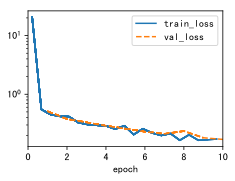

In [12]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

输出预测数据

In [ ]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)